In [7]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import scipy

from functools import partial
import pyDOE
from sklearn.gaussian_process.kernels import Matern

from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.gptools
import robustGP.acquisition.acquisition as ac
import robustGP.enrichment.Enrichment as enrich
import robustGP.optimisers as opt


In [8]:
plt.style.use('seaborn-v0_8')
plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    # 'font.sans-serif' : ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana'],
    'image.cmap': u'viridis',
    'figure.figsize': [8, 8],
    'savefig.dpi': 200
})

In [13]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    if initial_design is None:
        initial_design = 5 * NDIM
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin


bounds = np.asarray([[0, 1], [0, 1]])
# For plots
x, y = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
(XY, (xmg, ymg)) = tools.pairify((x, y))

xsmall, ysmall = np.linspace(0, 1, 4), np.linspace(0, 1, 4)
(XYsmall, (xmgsmall, ymgsmall)) = tools.pairify((xsmall, ysmall))

xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))

In [11]:
branin = initialize_branin(6)

In [5]:
maximum_variance = enrich.OneStepEnrichment(bounds)
maximum_variance.set_optim(opt.optimize_with_restart, **{"bounds": bounds, "nrestart": 20})

def variance(arg, X):
    return arg.predict(X, return_std=True)[1] ** 2

maximum_variance.set_criterion(variance, maxi=True)
branin.set_enrichment(maximum_variance)
branin.run(Niter=5)

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


[]

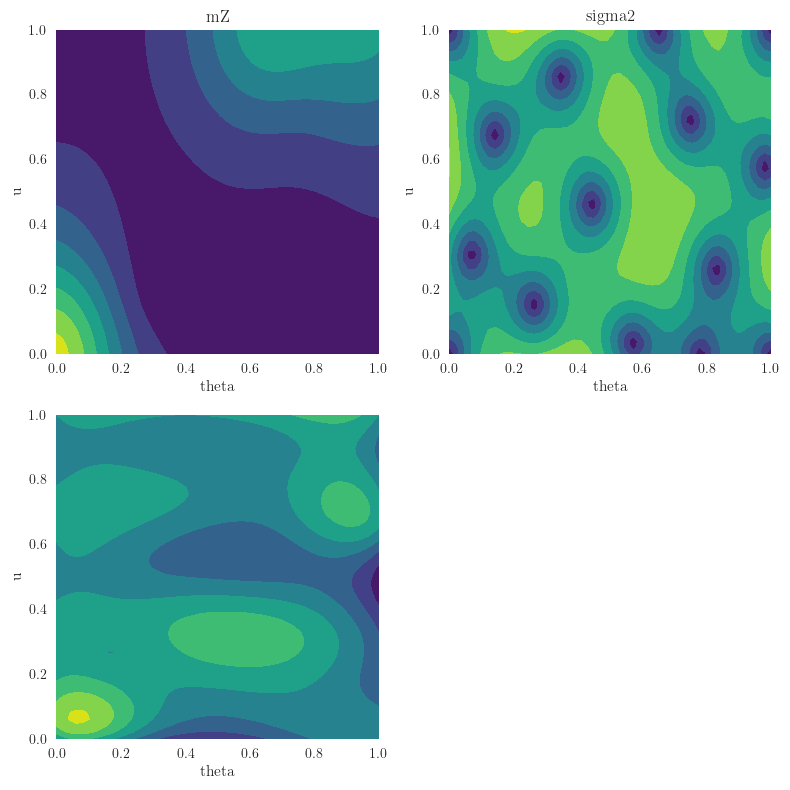

In [6]:
%matplotlib inline
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(50, 50).T)
plt.plot(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], 'x', color='white')
plt.xlabel(r"theta")
plt.ylabel(r"u")

plt.title(r"mZ")
# plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(50, 50).T)
plt.plot(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], 'x', color='white')
plt.xlabel(r"theta")
plt.ylabel(r"u")
plt.title(r"sigma2")
# plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, (m.reshape(50, 50) - branin.function(XY).reshape(50, 50)))
plt.plot(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], 'x', color='white')
plt.xlabel(r"theta")
plt.ylabel(r"u")
# plt.title(r"$J - m_Z$")
plt.tight_layout()

In [26]:
delta = branin.predict_GPdelta(XY, alpha=2)

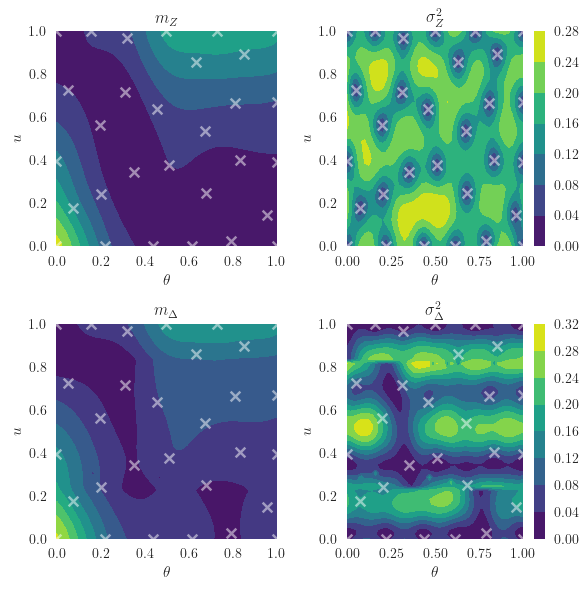

In [60]:
%matplotlib inline
plt.figure(figsize=(6, 6))
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(50, 50).T)
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', label='$\mathcal{X}$', alpha=0.5)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$u$")
plt.title(r"$m_Z$")
# plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(50, 50).T)
plt.colorbar()
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$u$")
plt.title(r"$\sigma^2_Z$")
# plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, delta[0].reshape(50, 50).T)
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.title(r"$m_{\Delta}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$u$")
plt.subplot(2, 2, 4)
plt.contourf(x, y, delta[1].reshape(50, 50).T)
plt.title(r"$\sigma^2_{\Delta}$")
plt.colorbar()
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$u$")
plt.tight_layout()

In [69]:
mstar = np.empty_like(y)
theta_star = np.empty_like(y)
for i, u in enumerate(y):
    mini = branin.get_conditional_minimiser(u)
    mstar[i] = mini.fun
    theta_star[i] = mini.x
    # cond_min = arg.get_conditional_minimiser(u)


In [84]:
res = []
for i, (th_star, u) in enumerate(zip(theta_star, y)):
    res.append(branin.predict(np.array([th_star, u]).reshape(-1, 2), return_std=True))
mstar, sigstar = zip(*res)
mstar = np.array(mstar)
sigstar = np.array(sigstar)

confint = lambda c: (mstar + c*sigstar).flatten()

(50, 1)

Text(0.5, 1.0, 'GP $Z^*$')

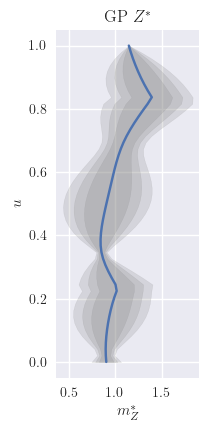

In [92]:
plt.figure(figsize=(2, 4))
plt.plot(mstar, y)
plt.fill_betweenx(y, confint(-1), confint(1), color="grey", alpha=0.2)
plt.fill_betweenx(y, confint(-1.5), confint(1.5), color="grey", alpha=0.2)
plt.fill_betweenx(y, confint(-2), confint(2), color="grey", alpha=0.2)
plt.tight_layout()
plt.ylabel(r'$u$')
plt.xlabel(r"$m^*_{Z}$")
plt.title(r'GP $Z^*$')

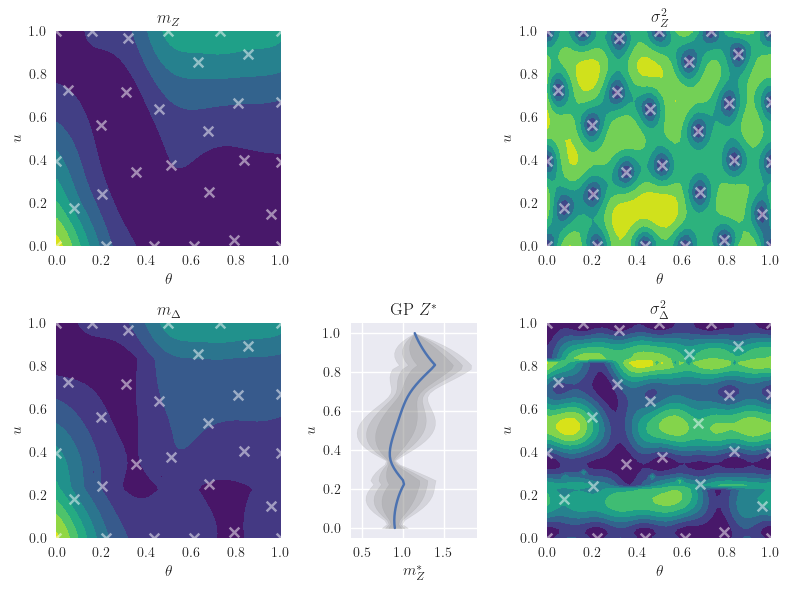

In [107]:
%matplotlib inline
axd = plt.figure(figsize=(8, 6), constrained_layout=True).subplot_mosaic(
    """
    AAA..BBB
    CCCDDEEE
    """
)

m, s = branin.predict(XY, return_std=True)
axd['A'].contourf(x, y, m.reshape(50, 50).T)
axd['A'].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', label='$\mathcal{X}$', alpha=0.5)
axd['A'].set_xlabel(r"$\theta$")
axd['A'].set_ylabel(r"$u$")
axd['A'].set_title(r"$m_Z$")

axd['B'].contourf(x, y, s.reshape(50, 50).T)
axd['B'].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
axd['B'].set_xlabel(r"$\theta$")
axd['B'].set_ylabel(r"$u$")
axd['B'].set_title(r"$\sigma^2_Z$")

axd['C'].contourf(x, y, delta[0].reshape(50, 50).T)
axd['C'].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
axd['C'].set_title(r"$m_{\Delta}$")
axd['C'].set_xlabel(r"$\theta$")
axd['C'].set_ylabel(r"$u$")

axd['E'].contourf(x, y, delta[1].reshape(50, 50).T)
axd['E'].set_title(r"$\sigma^2_{\Delta}$")
axd['E'].scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
axd['E'].set_xlabel(r"$\theta$")
axd['E'].set_ylabel(r"$u$")

axd['D'].plot(mstar, y)
axd['D'].fill_betweenx(y, confint(-1), confint(1), color="grey", alpha=0.2)
axd['D'].fill_betweenx(y, confint(-1.5), confint(1.5), color="grey", alpha=0.2)
axd['D'].fill_betweenx(y, confint(-2), confint(2), color="grey", alpha=0.2)
axd['D'].set_ylabel(r'$u$')
axd['D'].set_xlabel(r"$m^*_{Z}$")
axd['D'].set_title(r'GP $Z^*$')

plt.tight_layout()

In [34]:
def augmented_IMSE(arg, X, scenarios, integration_points):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, sd = arg.predict(int_points, return_std=True)
        return sd**2

    return ac.augmented_design(arg, X, scenarios, function_, {})

def augmented_IMSE_Delta(arg, X, scenarios, integration_points, alpha, beta=0):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, va = arg.predict_GPdelta(int_points, alpha=alpha, beta=beta)
        return va

    return ac.augmented_design(arg, X, scenarios, function_, {})

In [24]:
integration_points = pyDOE.lhs(2, 500, criterion="maximin", iterations=50)
aIMSE = augmented_IMSE(branin, XY, scenarios=None, integration_points=integration_points)
aIMSE_reg = augmented_IMSE(branin, XY, scenarios=None, integration_points=XY_s)


In [36]:
aIMSE_delta = {}
aIMSE_delta['0'] = augmented_IMSE_Delta(branin, XY, None, integration_points=XY_s, alpha=0)
aIMSE_delta['1'] = augmented_IMSE_Delta(branin, XY, None, integration_points=XY_s, alpha=1)
aIMSE_delta['2'] = augmented_IMSE_Delta(branin, XY, None, integration_points=XY_s, alpha=2)




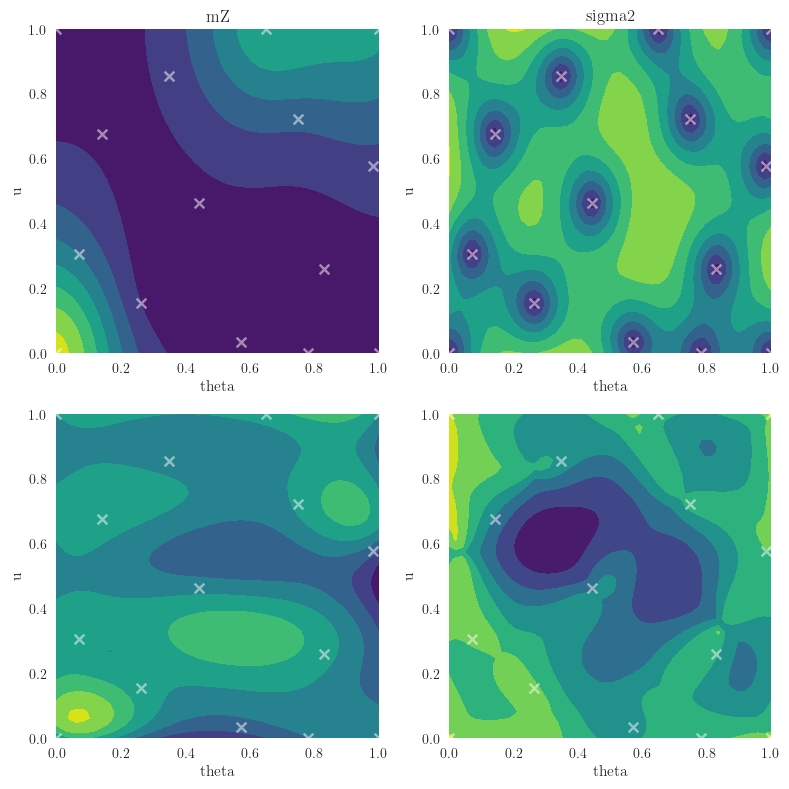

In [25]:
%matplotlib inline
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(50, 50).T)
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"theta")
plt.ylabel(r"u")

plt.title(r"mZ")
# plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(50, 50).T)
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"theta")
plt.ylabel(r"u")
plt.title(r"sigma2")
# plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, (m.reshape(50, 50) - branin.function(XY).reshape(50, 50)))
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"theta")
plt.ylabel(r"u")
# plt.title(r"$J - m_Z$")
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.contourf(x, y, aIMSE.reshape(50, 50))
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"theta")
plt.ylabel(r"u")
# plt.title(r"$J - m_Z$")
plt.tight_layout()


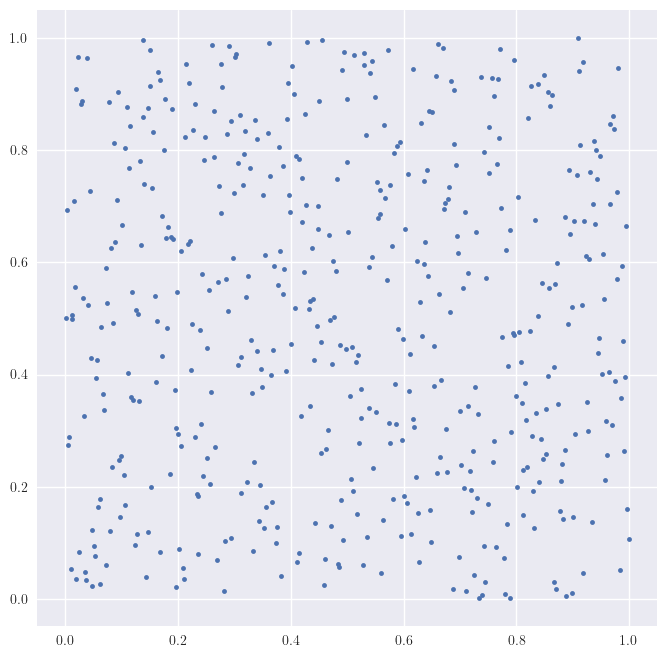

In [26]:
plt.plot(integration_points[:, 0], integration_points[:, 1], '.')

In [27]:
x_s, y_s = np.linspace(0, 1, 20), np.linspace(0, 1, 20)
(XY_s, (xmg_s, ymg_s)) = tools.pairify((x, y))

In [28]:
aIMSE_reg = augmented_IMSE(branin, XY, scenarios=None, integration_points=XY_s)

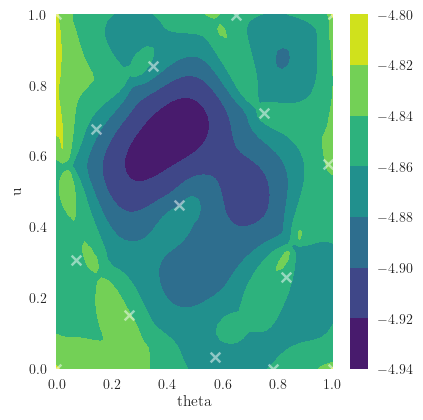

In [32]:
plt.subplot(2, 2, 4)
plt.contourf(x, y, np.log(aIMSE_reg).reshape(50, 50))
plt.colorbar()
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1], marker='x', c='white', alpha=0.5)
plt.xlabel(r"theta")
plt.ylabel(r"u")
# plt.title(r"$J - m_Z$")
plt.tight_layout()

In [1]:
import multiprocessing

multiprocessing.cpu_count()

96

In [17]:
import scipy
alpha=1.0
beta=0.0

def function_(arg):
    m, va = arg.predict_GPdelta(integration_points, alpha=alpha, beta=beta)
    return va
integration_points = pyDOE.lhs(2, 50, criterion="maximin", iterations=50)

def augmented_design(arg, X, args, verbose=False):
    if isinstance(arg, tuple):
        m, s = arg
    else:
        m, s = arg.predict(X, return_std=True)
    scenarios = lambda mp, sp: scipy.stats.norm.ppf(
            np.linspace(0.05, 0.95, 5, endpoint=True), loc=mp, scale=sp
        )
    augmented_meas = np.empty(len(m))
    for j, (m_, s_) in enumerate(zip(m, s)):
        augmented_sc = np.empty(5)
        for i, zi in enumerate(scenarios(m_, s_)):
            aug_gp = arg.augmented_GP(X[j], zi)
            augmented_sc[i] = function_(aug_gp).mean()
        augmented_meas[j] = augmented_sc.mean()
    return augmented_meas

augmented_design(branin, XYsmall, [])

array([0.04957287, 0.05485353, 0.05646105, 0.05085427, 0.0517465 ,
       0.05799316, 0.05651901, 0.05456026, 0.05613937, 0.06352187,
       0.05519248, 0.05580612, 0.04413959, 0.04462378, 0.06448256,
       0.06522243])

NameError: name 'np' is not defined